In [1]:
import os
os.chdir('../..')
import numpy as np
import torch
import pickle
from tqdm import tqdm
from rdkit.Chem import MolFromInchi
from rdkit.Chem.rdmolops import Kekulize


RDKit WARNING: [15:09:19] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
from molgrad.utils import DATA_PATH, EXAMPLE_PATH, MODELS_PATH
from molgrad.vis import molecule_importance
from molgrad.net import MPNNPredictor
from molgrad.train import DEVICE

os.makedirs(EXAMPLE_PATH, exist_ok=True)

Using backend: pytorch


In [3]:
with open(os.path.join(DATA_PATH, 'ppb', 'data_ppb.pt'), 'rb') as handle:
    inchis, values = pickle.load(handle)

with open(os.path.join(DATA_PATH, 'ppb', 'sim_ppb.pt'), 'rb') as handle:
    sim = pickle.load(handle)

preds = np.load(os.path.join(DATA_PATH, 'ppb', 'preds.npy'))
diff_true = np.load(os.path.join(DATA_PATH, 'ppb', 'diff_exp.npy'))
diff_hat = np.load(os.path.join(DATA_PATH, 'ppb', 'diff_hat.npy'))

In [4]:
sim.shape

(4634, 4634)

In [5]:
diff_true.shape

(4634, 4634)

In [6]:
diff_hat.shape

(4634, 4634)

In [7]:
ligand_i = []
ligand_j = []
values_i = []
values_j = []
preds_i = []
preds_j = []

long_sim = []
long_true = []
long_hat = []

for idx_i, (inchi_i, exp_i, pred_i) in enumerate(zip(inchis, values, preds)):
    for idx_j, (inchi_j, exp_j, pred_j) in enumerate(zip(inchis, values, preds)):
        if idx_i < idx_j:
            ligand_i.append(inchi_i)
            ligand_j.append(inchi_j)
            values_i.append(exp_i)
            values_j.append(exp_j)
            preds_i.append(pred_i)
            preds_j.append(pred_j)
            long_sim.append(sim[idx_i, idx_j])
            long_true.append(diff_true[idx_i, idx_j])
            long_hat.append(diff_hat[idx_i, idx_j])
    

In [8]:
import pandas as pd
pd.set_option('display.max_rows', 1000)

df_pairs = pd.DataFrame({'inchi_i': ligand_i,
                         'inchi_j': ligand_j,
                         'values_i': values_i,
                         'values_j': values_j,
                         'preds_i': preds_i,
                         'preds_j': preds_j,
                         'similarity': long_sim,
                         'diff_exp': long_true,
                         'diff_pred': long_hat})


In [9]:
def sali_index(sim, diff):
    return np.abs(diff) / (1 - sim)

In [10]:
df_pairs = df_pairs.loc[df_pairs['similarity'] < 1.0]
df_pairs['sali_exp'] = sali_index(df_pairs['similarity'], df_pairs['diff_exp'])
df_pairs['sali_pred'] = sali_index(df_pairs['similarity'], df_pairs['diff_pred'])
df_pairs.sort_values('sali_pred', ascending=False, inplace=True)
df_pairs.reset_index(inplace=True)

In [11]:
df_pairs.head(n=800)

,index,inchi_i,inchi_j,values_i,values_j,preds_i,preds_j,similarity,diff_exp,diff_pred,sali_exp,sali_pred
0,1407321,InChI=1S/C56H78N2O16/c1-57(23-19-37-33-45(65-7...,InChI=1/C56H78N2O16.2ClH/c1-57(23-19-37-33-45(...,35.000000,31.000000,49.821598,45.544285,0.990385,4.000000e+00,4.277313,416.000942,444.841637
1,9305767,InChI=1S/C19H16ClF3N6O2/c20-15-9-27-17(28-11-1...,InChI=1S/C19H16ClF3N6O3/c20-15-9-26-17(27-11-1...,14.000000,70.000000,14.519623,101.094330,0.777778,-5.600000e+01,-86.574707,252.000015,389.586205
2,1259697,InChI=1S/C43H66O15/c1-20-38(49)32(55-23(4)44)1...,InChI=1/C43H66O14/c1-21-38(48)33(54-24(4)44)19...,25.000000,80.000000,32.257607,81.960060,0.871345,-5.500000e+01,-49.702454,427.500046,386.323659
3,1258417,InChI=1S/C43H66O15/c1-20-38(49)32(55-23(4)44)1...,InChI=1S/C43H66O14/c1-21-38(48)33(54-24(4)44)1...,25.000000,80.000000,32.257607,81.628769,0.871345,-5.500000e+01,-49.371162,427.500046,383.748622
4,7267000,InChI=1/C41H64O13/c1-20-36(46)29(42)16-34(49-2...,InChI=1/C41H64O14/c1-19-36(47)28(42)15-34(50-1...,94.250000,24.000000,80.891319,29.832529,0.865031,7.025000e+01,51.058792,520.488526,378.299153
5,7268421,InChI=1/C41H64O13/c1-20-36(46)29(42)16-34(49-2...,InChI=1S/C41H64O14/c1-19-36(47)28(42)15-34(50-...,94.250000,22.500000,80.891319,29.832527,0.865031,7.175000e+01,51.058792,531.602160,378.299153
6,3067879,InChI=1S/C41H64O13/c1-20-36(46)29(42)16-34(49-...,InChI=1S/C41H64O14/c1-19-36(47)28(42)15-34(50-...,94.500000,22.500000,80.446823,29.832527,0.865031,7.200000e+01,50.614296,533.454433,375.005841
7,3066458,InChI=1S/C41H64O13/c1-20-36(46)29(42)16-34(49-...,InChI=1/C41H64O14/c1-19-36(47)28(42)15-34(50-1...,94.500000,24.000000,80.446823,29.832529,0.865031,7.050000e+01,50.614296,522.340799,375.005841
8,1251192,InChI=1S/C41H64O14/c1-19-36(47)28(42)15-34(50-...,InChI=1/C41H64O13/c1-20-36(46)29(42)16-34(49-2...,25.499999,94.250000,30.630066,80.891319,0.865031,-6.875000e+01,-50.261253,509.374892,372.390117
9,1249909,InChI=1S/C41H64O14/c1-19-36(47)28(42)15-34(50-...,InChI=1S/C41H64O13/c1-20-36(46)29(42)16-34(49-...,25.499999,94.500000,30.630066,80.446823,0.865031,-6.900000e+01,-49.816757,511.227165,369.096805


In [12]:
model_pt = os.path.join(MODELS_PATH, 'ppb_noHs.pt')

model = MPNNPredictor(node_in_feats=49,
                      edge_in_feats=10,
                      global_feats=4,
                      n_tasks=1).to(DEVICE) 
model.load_state_dict(torch.load(model_pt,
                                 map_location=DEVICE))

<All keys matched successfully>

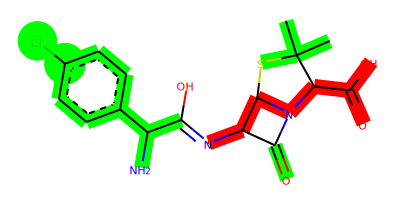

In [13]:
inchi_i, inchi_j = df_pairs.loc[77, 'inchi_i'],  df_pairs.loc[77, 'inchi_j']
mol_i, mol_j = MolFromInchi(inchi_i), MolFromInchi(inchi_j)
svg, img, _, _, global_importance = molecule_importance(mol_i,
                                                      model,
                                                      task=0,
                                                      version=2,
                                                      vis_factor=0.5,
                                                      eps=1e-4,
                                                      addHs=False)
img

In [14]:
with open(os.path.join(EXAMPLE_PATH, "ppb_cliff_one_pos.svg"), "w+") as handle:
    handle.write(svg)

In [18]:
svg, img, _, _, global_importance = molecule_importance(mol_j,
                                                      model,
                                                      task=0,
                                                      version=2,
                                                      vis_factor=0.5,
                                                      eps=1e-4,
                                                      addHs=False)
with open(os.path.join(EXAMPLE_PATH, "ppb_cliff_one_neg.svg"), "w+") as handle:
    handle.write(svg)

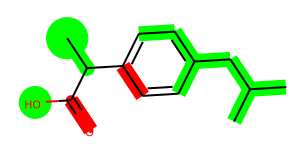

In [19]:
inchi_i, inchi_j = df_pairs.loc[90, 'inchi_i'], df_pairs.loc[90, 'inchi_j']


mol_i, mol_j = MolFromInchi(inchi_i), MolFromInchi(inchi_j)


svg, img, _, _, global_importance = molecule_importance(mol_i,
                                                      model,
                                                      task=0,
                                                      version=2,
                                                      vis_factor=0.5,
                                                      eps=1e-4,
                                                      addHs=False,
                                                      img_width=300,
                                                      img_height=150)
img

In [20]:
with open(os.path.join(EXAMPLE_PATH, "ppb_cliff_two_pos.svg"), "w+") as handle:
    handle.write(svg)

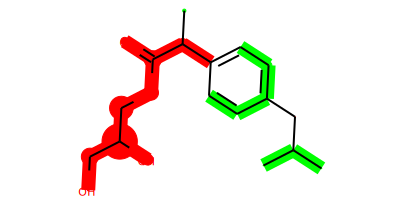

In [21]:
svg, img, _, _, global_importance = molecule_importance(mol_j,
                                                      model,
                                                      task=0,
                                                      version=2,
                                                      vis_factor=1,
                                                      eps=1e-4,
                                                      addHs=False)
img

In [22]:
with open(os.path.join(EXAMPLE_PATH, "ppb_cliff_two_neg.svg"), "w+") as handle:
    handle.write(svg)